# Trap record sucess prediction

The goal of this notebook is to construct a prediction of the page views a song can get on Genius, a website providing lyrics and their explanations for different songs. We recognize that maybe this is not an ideal metric for a sucess of a song, however we believe that for the purposes of purely academic inquiry, it should get the job done. 

The prediction will be based on features extracted from the lyrics of the songs in a traditional way i.e. by checing the length of the lyrics, number of unique words etc, as well as using topic modeling (LDA to be precise).

In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from nltk.corpus import stopwords 
import json
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [5]:
import os
#Get list of json files
json_list = os.listdir('/Users/mkunstler/Desktop/WNE/ML2/projekt/json_files/')

#Function to generate dataframe with song lyrics
def create_artist_df(json_files_list):

    #Loop through files
    rows = []
    for file in json_files_list:

        #Open each file
        f = open('json_files/{filename}'.format(filename=file))
        data = json.load(f)

        #Extract information we need

        for song in data['songs']:
            try:
                rows.append({'artist':song['artist'], 'title':song['title'], 'lyrics':song['lyrics'], 'page_views':song['stats']['pageviews'], 'release_date':song['release_date']})
            except:
                rows.append({'artist':song['artist'], 'title':song['title'], 'lyrics':song['lyrics'], 'page_views':'', 'release_date':song['release_date']})


    
    artist_df = pd.DataFrame(rows, columns=['artist', 'title', 'lyrics', 'page_views', 'release_date'])
    return artist_df

artist_df = create_artist_df(json_list)

In [6]:
artist_df['original_lyrics'] = artist_df['lyrics']
artist_df.head()

,artist,title,lyrics,page_views,release_date,original_lyrics
0,Migos,Bad and Boujee,TranslationsPortuguêsРусскийItalianoAzərbaycan...,9397531,2016-08-27,TranslationsPortuguêsРусскийItalianoAzərbaycan...
1,Migos,Versace (Remix),Versace (Remix) Lyrics[Intro: Drake & Quavo]\n...,2873846,2013-06-22,Versace (Remix) Lyrics[Intro: Drake & Quavo]\n...
2,Migos,T-Shirt,TranslationsPortuguêsT-Shirt Lyrics[Intro]\nNa...,2771927,2017-01-06,TranslationsPortuguêsT-Shirt Lyrics[Intro]\nNa...
3,Migos,Slippery,Slippery Lyrics[Intro]\nDe-de-de-de-de-de-de-d...,2049464,2017-01-27,Slippery Lyrics[Intro]\nDe-de-de-de-de-de-de-d...
4,Migos,Walk It Talk It,TranslationsMigos - Walk It Talk It ft. Drake ...,1521048,2018-01-26,TranslationsMigos - Walk It Talk It ft. Drake ...


In [7]:
import re
def clean_txt(song):

    #Remove unnecessary characters and first lines, as they contain information about translation which we don't need
    song = ' '.join(song.split("\n")[1:])
    song = re.sub("[\[].*?[\]]", "", song)

    #There are weird endings in the lyrics of each song, so we should remove them with regular expressions (up to 3 digid number + Embed)
    song = re.sub('\d{3}Embed$|\d{2}Embed$|\d{1}Embed$', '', song)
    return song

artist_df['lyrics'] = artist_df['original_lyrics'].apply(lambda x: clean_txt(x))

#Check the new endings
for i in range(10):
    print('Old endings: ' + artist_df['original_lyrics'][i][-10:] + ' VS New endings: ' + artist_df['lyrics'][i][-10:])

#It worked :)

Old endings: i)590Embed VS New endings:  (Lil Uzi)
Old endings: ce235Embed VS New endings: ce Versace
Old endings: ou183Embed VS New endings: a told you
Old endings: ey)98Embed VS New endings:  hey, hey)
Old endings: it103Embed VS New endings:  I talk it
Old endings: f)103Embed VS New endings: ry (Wroof)
Old endings: too62Embed VS New endings: ck out too
Old endings: gle82Embed VS New endings: the jungle
Old endings: cha48Embed VS New endings: ght witcha
Old endings: ht158Embed VS New endings: ight night


In [8]:
stop_words = set(stopwords.words('english'))

def len_lyrics(song):
    return len(song.split())

def len_unique_lyrics(song):
    return len(list(set(song.split())))

def rmv_stop_words(song):
    song = [w for w in song.split() if not w in stop_words] 
    return len(song)

def rmv_set_stop_words(song):
    song = [w for w in song.split() if not w in stop_words] 
    return len(list(set(song)))

In [9]:
artist_df['len_lyrics'] = artist_df['lyrics'].apply(lambda x: len_lyrics(x))
artist_df['len_unique_lyrics'] = artist_df['lyrics'].apply(lambda x: len_unique_lyrics(x))
artist_df['without_stop_words'] = artist_df['lyrics'].apply(lambda x: rmv_stop_words(x))
artist_df['unique_without_stop_words'] = artist_df['lyrics'].apply(lambda x: rmv_set_stop_words(x))

In [10]:
artist_df.head()

,artist,title,lyrics,page_views,release_date,original_lyrics,len_lyrics,len_unique_lyrics,without_stop_words,unique_without_stop_words
0,Migos,Bad and Boujee,"You know, young rich niggas You know somethin'...",9397531,2016-08-27,TranslationsPortuguêsРусскийItalianoAzərbaycan...,1231,461,850,415
1,Migos,Versace (Remix),"(Zaytoven) Yeah Oh shit, man, who that is? Sho...",2873846,2013-06-22,Versace (Remix) Lyrics[Intro: Drake & Quavo]\n...,808,381,565,331
2,Migos,T-Shirt,Nard & B TrenchWerk (Ayy) Mama told me (Ayy) ...,2771927,2017-01-06,TranslationsPortuguêsT-Shirt Lyrics[Intro]\nNa...,585,272,427,232
3,Migos,Slippery,De-de-de-de-de-de-de-de-Deko OG Parker Pop a...,2049464,2017-01-27,Slippery Lyrics[Intro]\nDe-de-de-de-de-de-de-d...,870,419,650,380
4,Migos,Walk It Talk It,"Yeah, yeah (Deko) Woah, hold on (OG Parker) Uh...",1521048,2018-01-26,TranslationsMigos - Walk It Talk It ft. Drake ...,1169,335,853,294


In [11]:
#Counting long words in the songs. For the purposes of this analysis a long word is said to have 8 or more letters.
#The criterion is mostly arbitrary, but we believe these words should mostly have 3 syllables or more

def count_long_words(df):
    def count_long_words_in_string(s):
        return len([w for w in s.split() if len(w.strip('()')) > 7])
    df['long_words_count'] = df['lyrics'].apply(count_long_words_in_string)
    return df

artist_df = count_long_words(artist_df)

In [12]:
#Counting the number of ad-libs in the song
def count_open_parentheses(df):
    df['adlib_count'] = df['lyrics'].apply(lambda x: x.count('('))
    return df

artist_df = count_open_parentheses(artist_df)

In [13]:
def avg_word_length(df):
    def avg_word_length_in_string(s):
        words = [w for w in s.split() if '(' not in w and ')' not in w]
        total_length = sum(len(w) for w in words)
        return total_length / len(words) if words else 0
    df['avg_word_length'] = df['lyrics'].apply(avg_word_length_in_string)
    return df

artist_df = avg_word_length(artist_df)

In [14]:
def stop_word_ratio(df):
    df['stop_word_ratio'] = (df['len_lyrics'] - df['without_stop_words']) / df['len_lyrics']
    return df

artist_df = stop_word_ratio(artist_df)

In [15]:
def unique_words_per_word(df):
    df['unique_word_per_word'] =  df['len_unique_lyrics'] / df['len_lyrics']
    return df

artist_df = unique_words_per_word(artist_df)

Below, the features are standardized within each artist, meaning that the standarization occurs after dividing the dataframe into seprate ones, each containing one artist, and before merging the dataframes back together (this not tecnically how it is happening, but we find this description more intuitive and it leads to the same results).

In [16]:
def calculate_stats_by_group(df, value_column):
    df[value_column] = pd.to_numeric(df[value_column])
    # Group the dataframe by the "artist" column
    grouped = df.groupby('artist')
    
    # Calculate the average and standard deviation of the values in the chosen column
    avg = grouped[value_column].mean()
    std = grouped[value_column].std()
    
    # Merge the resulting dataframes back into the original dataframe
    df = df.merge(avg.reset_index(), on='artist', suffixes=('', '_avg'))
    df = df.merge(std.reset_index(), on='artist', suffixes=('', '_std'))
    
    # Calculate the number of standard deviations away from the average for each value
    df[f'{value_column}_standardized'] = (df[value_column] - df[f'{value_column}_avg']) / df[f'{value_column}_std']
    
    df.drop(f'{value_column}_std', inplace=True, axis = 1)
    df.drop(f'{value_column}_avg', inplace=True, axis = 1)
    return df

In [17]:
# Transforming the features
fet_cols_orig = ['len_lyrics', 'len_unique_lyrics', 'without_stop_words', 'unique_without_stop_words', 
                 'long_words_count', 'adlib_count', 'avg_word_length', 'stop_word_ratio', 'unique_word_per_word']

for col in range(len(fet_cols_orig)):
    print(fet_cols_orig[col])
    artist_df = calculate_stats_by_group(artist_df, fet_cols_orig[col])
    artist_df.drop(fet_cols_orig[col], inplace=True, axis = 1)
    
# And the label
artist_df = calculate_stats_by_group(artist_df, 'page_views')

len_lyrics
len_unique_lyrics
without_stop_words
unique_without_stop_words
long_words_count
adlib_count
avg_word_length
stop_word_ratio
unique_word_per_word


In [18]:
artist_df.head()

,artist,title,lyrics,page_views,release_date,original_lyrics,len_lyrics_standardized,len_unique_lyrics_standardized,without_stop_words_standardized,unique_without_stop_words_standardized,long_words_count_standardized,adlib_count_standardized,avg_word_length_standardized,stop_word_ratio_standardized,unique_word_per_word_standardized,page_views_standardized
0,Migos,Bad and Boujee,"You know, young rich niggas You know somethin'...",9397531.0,2016-08-27,TranslationsPortuguêsРусскийItalianoAzərbaycan...,2.219073,1.856665,2.156433,1.916397,1.423906,2.140562,-0.136579,0.228606,-0.312699,3.923808
1,Migos,Versace (Remix),"(Zaytoven) Yeah Oh shit, man, who that is? Sho...",2873846.0,2013-06-22,Versace (Remix) Lyrics[Intro: Drake & Quavo]\n...,0.020273,0.842441,0.012413,0.783950,2.610494,-1.092508,1.142537,0.079310,1.192843,0.729994
2,Migos,T-Shirt,Nard & B TrenchWerk (Ayy) Mama told me (Ayy) ...,2771927.0,2017-01-06,TranslationsPortuguêsT-Shirt Lyrics[Intro]\nNa...,-1.138906,-0.539441,-1.025744,-0.550720,-0.806880,0.254604,0.575966,-0.443064,1.090800,0.680097
3,Migos,Slippery,De-de-de-de-de-de-de-de-Deko OG Parker Pop a...,2049464.0,2017-01-27,Slippery Lyrics[Intro]\nDe-de-de-de-de-de-de-d...,0.342555,1.324197,0.651857,1.444544,0.284781,1.062872,0.047086,-0.736341,1.349142,0.326400
4,Migos,Walk It Talk It,"Yeah, yeah (Deko) Woah, hold on (OG Parker) Uh...",1521048.0,2018-01-26,TranslationsMigos - Walk It Talk It ft. Drake ...,1.896790,0.259261,2.179001,0.285134,-0.806880,1.035930,-2.340890,-0.439127,-1.676754,0.067702


In [28]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string
import spacy
import torch
import transformers 

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

import math

In [20]:
#!python -m spacy download en

In [21]:
nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    #Add further words that do not carry much meaning, yet they are quite frequently used in songs
    useless_words = useless_words + ['ooh', 'oh', 'wow', 'nigga', 'niggas', 'yeah', 'huh', 'woo', 'ayy', 'em', 'woah', 'ya', 'ow', 'ah', 'trap', 'uh']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

#Clean songs with our cleaning function
artist_df['clean_songs'] = artist_df.lyrics.apply(lambda x: clean_string(text = x, stem = 'Lem'))

In [22]:
#Compare song before and after cleaning
print('Before cleaning: ' +  artist_df['lyrics'][0][:500])
print('\n\nAfter cleaning: ' +  artist_df['clean_songs'][0][:500])

Before cleaning: You know, young rich niggas You know somethin', we ain't really never had no old money We got a whole lotta new money though, hah (If Young Metro don't trust you, I'm gon' shoot you) Hey   Raindrop (Drip), drop-top (Drop-top) Smokin' on cookie in the hotbox (Cookie) Fuckin' on your bitch, she a thot, thot (Thot) Cookin' up dope in the crockpot (Pot) We came from nothin' to somethin', nigga (Hey) I don't trust nobody, grip the trigger (Nobody) Call up the gang and they come and get ya (Gang) Cry 


After cleaning: know young rich know somethin aint really never old money got whole lotta new money though hah young metro dont trust im gon shoot hey raindrop drip droptop droptop smokin cookie hotbox cookie fuckin bitch thot thot thot cookin dope crockpot pot came nothin somethin hey dont trust nobody grip trigger nobody call gang come get gang cry river give tissue hey bitch bad bougie bad cookin dope uzi blaow savage ruthless savage got  hundredrounds grrah bitch bad boug

In [23]:
import warnings
warnings.filterwarnings("ignore") #ignoring popping up warnings

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(artist_df["clean_songs"]), #filtering with document frequency
                                tokenizer = tokenizer.tokenize
)
tf = tf_vectorizer.fit_transform(artist_df["clean_songs"])
tf_feature_names = tf_vectorizer.get_feature_names()

In [24]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [29]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

measures_specific = []

for n_topics in range(2,21,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 5, 
                                    random_state = 42)
                
    lda.fit(tf)
    
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20


In [36]:
measures_specific_df_lda = pd.DataFrame(measures_specific)
measures_specific_df_lda.columns = ['avg_coherence', 'n_topics']


measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
0,-226.932830,2
1,-289.394881,3
2,-347.107093,4
4,-364.901382,6
3,-369.071842,5
6,-379.071112,8
8,-394.236965,10
5,-394.816114,7
7,-395.861588,9


We choose 6 topics, because it has relatively high average topic coherence, while having more than 5 topics which we wanted to provide the models with more variables and to extract all different topics.

In [37]:
lda = LatentDirichletAllocation(n_components = 6,
                                learning_method = 'online', 
                                learning_offset = 10.0,
                                max_iter = 50, 
                                random_state = 12)
lda.fit(tf) # tfi

topics_lists = []

for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    topics_lists.append(top_terms_list)
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['love', 'time', 'cant', 'want', 'aint', 'take', 'feel', 'back', 'cause', 'gotta']
Topic 1:  ['baby', 'dope', 'young', 'move', 'let', 'versace', 'call', 'go', 'house', 'fuck']
Topic 2:  ['money', 'aint', 'lot', 'shit', 'pain', 'many', 'numb', 'go', 'hey', 'fuck']
Topic 3:  ['let', 'drunk', 'skrt', 'let know', 'dawg', 'know let', 'wan', 'right', 'high', 'killin']
Topic 4:  ['bitch', 'shit', 'as', 'gang', 'fuck', 'aint', 'boy', 'god', 'lil', 'talk']
Topic 5:  ['bitch', 'aint', 'go', 'fuck', 'put', 'night', 'gon', 'straight', 'make', 'hey']


- Topic 0: love
- Topic 1: young life / hustle culture / drugs
- Topic 2: money / the pains of richness
- Topic 3: intoxication / recklessness
- Topic 4: life in a gang
- Topic 5: nightlife

In [38]:
df_topics_for_songs = pd.DataFrame(lda.transform(tf).tolist())

df_topics_for_songs.sample(10)

,0,1,2,3,4,5
219,0.215851,0.000592,0.202768,0.000590,0.579608,0.000591
120,0.000548,0.757289,0.000548,0.000546,0.240522,0.000548
215,0.000495,0.000498,0.764669,0.000494,0.150546,0.083298
347,0.000572,0.000571,0.309150,0.000567,0.000571,0.688569
256,0.055954,0.663525,0.092009,0.000593,0.187320,0.000598
172,0.464292,0.000892,0.150242,0.000888,0.000892,0.382794
285,0.000762,0.000762,0.071799,0.000756,0.455972,0.469948
254,0.514953,0.418013,0.065162,0.000620,0.000627,0.000625
313,0.362268,0.000668,0.635077,0.000662,0.000664,0.000662
71,0.093873,0.057133,0.090434,0.000484,0.656897,0.101179


Finally, we have all of the features prepared

In [39]:
df_artists_final = pd.merge(artist_df, round(df_topics_for_songs*100, 3), left_index=True, right_index=True)
df_artists_final = df_artists_final.rename(columns = {0 : "Topic_0", 1 : "Topic_1", 2 : "Topic_2", 3 : "Topic_3", 4 : "Topic_4", 5 : "Topic_5"})
df_artists_final.head()

,artist,title,lyrics,page_views,release_date,original_lyrics,len_lyrics_standardized,len_unique_lyrics_standardized,without_stop_words_standardized,unique_without_stop_words_standardized,...,stop_word_ratio_standardized,unique_word_per_word_standardized,page_views_standardized,clean_songs,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Migos,Bad and Boujee,"You know, young rich niggas You know somethin'...",9397531.0,2016-08-27,TranslationsPortuguêsРусскийItalianoAzərbaycan...,2.219073,1.856665,2.156433,1.916397,...,0.228606,-0.312699,3.923808,know young rich know somethin aint really neve...,0.029,12.406,25.395,0.029,16.492,45.649
1,Migos,Versace (Remix),"(Zaytoven) Yeah Oh shit, man, who that is? Sho...",2873846.0,2013-06-22,Versace (Remix) Lyrics[Intro: Drake & Quavo]\n...,0.020273,0.842441,0.012413,0.783950,...,0.079310,1.192843,0.729994,zaytoven shit man shoutout migos shoutout zayt...,15.295,66.114,0.040,0.040,0.040,18.471
2,Migos,T-Shirt,Nard & B TrenchWerk (Ayy) Mama told me (Ayy) ...,2771927.0,2017-01-06,TranslationsPortuguêsT-Shirt Lyrics[Intro]\nNa...,-1.138906,-0.539441,-1.025744,-0.550720,...,-0.443064,1.090800,0.680097,nard b trenchwerk mama told sell work mama sev...,0.054,56.796,0.054,0.054,0.054,42.987
3,Migos,Slippery,De-de-de-de-de-de-de-de-Deko OG Parker Pop a...,2049464.0,2017-01-27,Slippery Lyrics[Intro]\nDe-de-de-de-de-de-de-d...,0.342555,1.324197,0.651857,1.444544,...,-0.736341,1.349142,0.326400,dededededededededeko og parker pop perky start...,0.036,2.510,9.097,0.036,22.490,65.831
4,Migos,Walk It Talk It,"Yeah, yeah (Deko) Woah, hold on (OG Parker) Uh...",1521048.0,2018-01-26,TranslationsMigos - Walk It Talk It ft. Drake ...,1.896790,0.259261,2.179001,0.285134,...,-0.439127,-1.676754,0.067702,deko hold og parker walk like talk walk walk l...,0.034,4.486,0.034,0.034,86.868,8.543


In [40]:
save_object(df_artists_final, 'df_artists_final.pkl')

For preprocesing we decided to keep the observations with missing label, as it resulted in much more robust topics. If we excluded these songs, we believe that the topic models got overlearned.

In [41]:
df_artists_final = df_artists_final.dropna(axis=0, subset=['page_views'])

(array([344.,  34.,  11.,   6.,   3.,   4.,   0.,   0.,   0.,   1.]),
 array([5.6600000e+03, 1.6216280e+06, 3.2375960e+06, 4.8535640e+06,
        6.4695320e+06, 8.0855000e+06, 9.7014680e+06, 1.1317436e+07,
        1.2933404e+07, 1.4549372e+07, 1.6165340e+07]),
 <BarContainer object of 10 artists>)

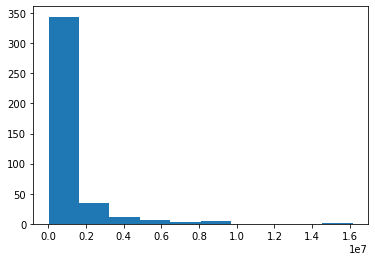

In [42]:
plt.hist(df_artists_final['page_views'])

(array([158., 139.,  40.,  25.,   8.,   8.,   7.,   4.,   4.,  10.]),
 array([-0.94027111, -0.44481587,  0.05063938,  0.54609462,  1.04154987,
         1.53700511,  2.03246036,  2.5279156 ,  3.02337085,  3.5188261 ,
         4.01428134]),
 <BarContainer object of 10 artists>)

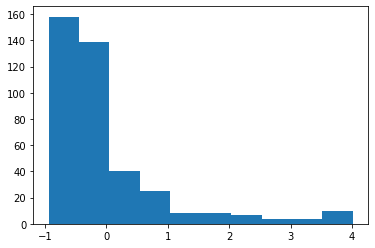

In [43]:
plt.hist(df_artists_final['page_views_standardized'])

# With standardized page views

In [44]:
features = [      'len_lyrics_standardized',
           'len_unique_lyrics_standardized',
          'without_stop_words_standardized',
   'unique_without_stop_words_standardized',
            'long_words_count_standardized',
                 'adlib_count_standardized',
             'avg_word_length_standardized',
             'stop_word_ratio_standardized',
        'unique_word_per_word_standardized',
                                  'Topic_0', 
                                  'Topic_1', 
                                  'Topic_2', 
                                  'Topic_3', 
                                  'Topic_4', 
                                  'Topic_5']

label = "page_views_standardized"

In [45]:
import seaborn as sns # statistical data visualization
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score #model evaluation metrics
from pyarrow import feather #data import/export
import time
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import sklearn.metrics as metrics

In [46]:
from sklearn.model_selection import train_test_split
  
X = df_artists_final[features]
y = df_artists_final[label]
  
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   random_state=12, 
                                   test_size=0.4)

## Baseline - linear regression

In [47]:
from sklearn.linear_model import LinearRegression

#For linear regression the topic variables should not be used, as they are colinear. 
# To that extent, we remove the 6th topic from the features
X = X.drop("Topic_5", axis = 1)

model_lr = LinearRegression().fit(X, y)

In [48]:
print('MAPE Value:',metrics.mean_absolute_percentage_error(y, model_lr.predict(X)))

MAPE Value: 2.645497506373969


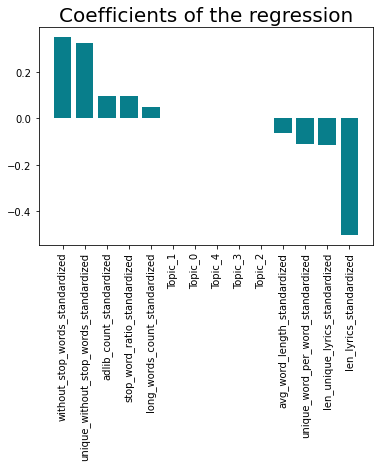

In [49]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model_lr.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Coefficients of the regression', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [50]:
model_lr.coef_

array([-0.50493131, -0.11317048,  0.35311951,  0.32580873,  0.04888122,
        0.0996854 , -0.06390531,  0.09906094, -0.11227909,  0.00233663,
        0.00365819,  0.0013111 ,  0.00143382,  0.0017279 ])

## Random forest

In [51]:
random_grid = {'max_depth': [2, 4, 8, 10, 15, 20],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [20, 50, 75, 100, 200]}

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 3, random_state=12, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 2}

In [58]:
model_rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 3, random_state = 12)

# Fitting the Random Forest Regression model to the data
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=12)

In [59]:
# Predicting the target values of the test set
y_pred = model_rf.predict(X_test)

# RMSE (Root Mean Square Error)
r2_rf = metrics.mean_absolute_percentage_error(y_test, y_pred)
print("\nR2 score for random forest: ", r2_rf)


R2 score for random forest:  2.0320053192359335


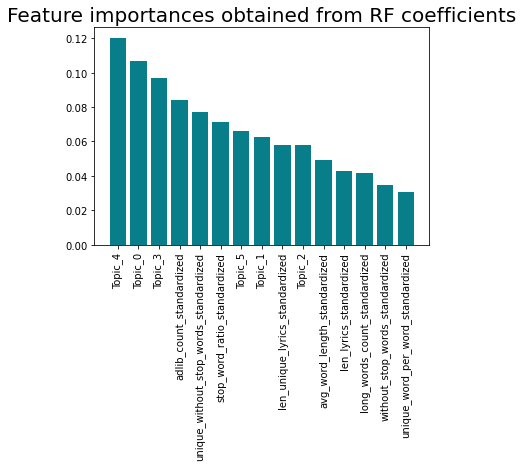

In [60]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_rf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from RF coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## XGBoost

In [61]:
random_grid = {'max_depth': [2, 4, 8, 10, 15, 20],
             'learning_rate': [0.1, 0.05, 0.01, 0.001],
             'n_estimators': [20, 50, 75, 100, 200]}

In [62]:
from xgboost import XGBRegressor

XGB = XGBRegressor()

XGB_random = RandomizedSearchCV(estimator = XGB, param_distributions = random_grid, n_iter = 50, cv = 3, random_state=12, n_jobs = -1)
XGB_random.fit(X_train, y_train)

XGB_random.best_params_

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.01}

In [63]:
RegModel=XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=200, objective='reg:linear', booster='gbtree')

#Creating the model on Training Data
XGB=RegModel.fit(X_train,y_train)
prediction=XGB.predict(X_test)

#Measuring Goodness of fit in Training data
print('MAPE Value:',metrics.mean_absolute_percentage_error(y_test, XGB.predict(X_test)))


[22:09:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
MAPE Value: 3.5389583877431967


## Decision Tree

In [65]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV

#Decision tree is a model simple enough, to where we can perform the grid search here as it wont take long

param_grid = {'criterion' : ["squared_error", "friedman_mse"],
              'max_depth' : [4, 6, 8, 10, 20],
              'min_samples_split': [2, 4, 8, 16, 32]}

regressor = DecisionTreeRegressor(random_state = 12)

DT_grid = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 3, n_jobs = -1)

DT_grid.fit(X_train, y_train)

DT_grid.best_params_

{'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 32}

In [66]:
DT_regressor = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 4, min_samples_split = 32, random_state = 12)

# fit the regressor with X and Y data
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_split=32, random_state=12)

## Results for standardized page views

In [67]:
print('MAPE Value:',metrics.mean_absolute_percentage_error(y_test, DT_regressor.predict(X_test)))

MAPE Value: 8.706312142960778


In [68]:
print('results in MAPE')
print('Linear regression: ',metrics.mean_absolute_percentage_error(y, model_lr.predict(X)))
print('Random Forest: ',metrics.mean_absolute_percentage_error(y_test, model_rf.predict(X_test)))
print('XGBoost: ',metrics.mean_absolute_percentage_error(y_test, XGB.predict(X_test)))
print('Decision Tree: ',metrics.mean_absolute_percentage_error(y_test, DT_regressor.predict(X_test)))

results in MAPE
Linear regression:  2.645497506373969
Random Forest:  2.0320053192359335
XGBoost:  3.5389583877431967
Decision Tree:  8.706312142960778


# With non-standardized page views

In [73]:
features = [      'len_lyrics_standardized',
           'len_unique_lyrics_standardized',
          'without_stop_words_standardized',
   'unique_without_stop_words_standardized',
            'long_words_count_standardized',
                 'adlib_count_standardized',
             'avg_word_length_standardized',
             'stop_word_ratio_standardized',
        'unique_word_per_word_standardized',
                                  'Topic_0', 
                                  'Topic_1', 
                                  'Topic_2', 
                                  'Topic_3', 
                                  'Topic_4', 
                                  'Topic_5']

label_nonst = "page_views"

In [74]:
X_nonst = df_artists_final[features]
y_nonst = df_artists_final[label]
  
# using the train test split function
X_train_nonst, X_test_nonst, y_train_nonst, y_test_nonst = train_test_split(X, y,
                                   random_state=12, 
                                   test_size=0.4)

## Baseline - linear regression

In [75]:
#For linear regression the topic variables should not be used, as they are colinear. 
# To that extent, we remove the 6th topic from the features
try:
    X_nonst = X_nonst.drop("Topic_5", axis = 1)
except:
    print("column already removed")

model_lr_nonst = LinearRegression().fit(X_nonst, y_nonst)

In [76]:
y_pred = model_lr_nonst.predict(X_nonst)

print('MAPE Value:',metrics.mean_absolute_percentage_error(y, model_lr_nonst.predict(X_nonst)))

MAPE Value: 2.645497506373969


In [77]:
model_lr_nonst.coef_

array([-0.50493131, -0.11317048,  0.35311951,  0.32580873,  0.04888122,
        0.0996854 , -0.06390531,  0.09906094, -0.11227909,  0.00233663,
        0.00365819,  0.0013111 ,  0.00143382,  0.0017279 ])

## Random forest

In [79]:
random_grid = {'max_depth': [2, 4, 8, 10, 15, 20],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [20, 50, 75, 100, 200]}

In [80]:
rf_nonst = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf_nonst, param_distributions = random_grid, n_iter = 150, cv = 3, random_state=12, n_jobs = -1)

rf_random.fit(X_train_nonst, y_train_nonst)

rf_random.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/virt/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/virt/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/virt/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

{'n_estimators': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [81]:
# Initializing the Random Forest Regression model with 10 decision trees
model_rf_nonst = RandomForestRegressor(n_estimators = 20, min_samples_split =10, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 2, random_state = 12)

# Fitting the Random Forest Regression model to the data
model_rf_nonst.fit(X_train_nonst, y_train_nonst)

RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=20, random_state=12)

In [83]:
# Predicting the target values of the test set
y_pred = model_rf_nonst.predict(X_test_nonst)

# RMSE (Root Mean Square Error)
r2_rf = metrics.mean_absolute_percentage_error(y_test_nonst, y_pred)
print("\nR2 score for random forest: ", r2_rf)


R2 score for random forest:  2.5284718248402247


## XGBoost

In [84]:
random_grid = {'max_depth': [2, 4, 8, 10, 15, 20],
             'learning_rate': [0.1, 0.05, 0.01, 0.001],
             'n_estimators': [20, 50, 75, 100, 200]}

In [85]:
from xgboost import XGBRegressor

XGB_nonst = XGBRegressor()

XGB_random = RandomizedSearchCV(estimator = XGB_nonst, param_distributions = random_grid, n_iter = 50, cv = 3, random_state=12, n_jobs = -1)
XGB_random.fit(X_train_nonst, y_train_nonst)

XGB_random.best_params_

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.01}

In [86]:
RegModel_nonst=XGBRegressor(max_depth=2, learning_rate=0.01, n_estimators=200, objective='reg:linear', booster='gbtree')

#Creating the model on Training Data
XGB_nonst=RegModel_nonst.fit(X_train_nonst,y_train_nonst)
prediction=XGB_nonst.predict(X_test_nonst)

#Measuring Goodness of fit in Training data
print('MAPE Value:',metrics.mean_absolute_percentage_error(y_test_nonst, XGB_nonst.predict(X_test_nonst)))


[22:12:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
MAPE Value: 4.572925380104274


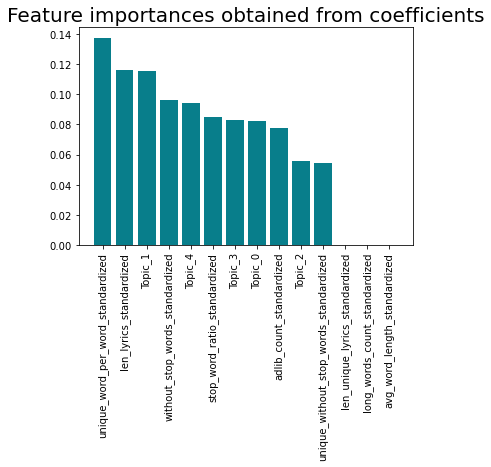

In [87]:
importances = pd.DataFrame(data={
    'Attribute': X_train_nonst.columns,
    'Importance': XGB_nonst.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Decision Tree

In [88]:
from sklearn.tree import DecisionTreeRegressor 

param_grid = {'criterion' : ["squared_error", "friedman_mse"],
              'max_depth' : [4, 6, 8, 10, 20],
              'min_samples_split': [2, 4, 8, 16, 32]}

regressor_nonst = DecisionTreeRegressor(random_state = 12)

DT_grid = GridSearchCV(estimator = regressor_nonst, param_grid = param_grid, cv = 3, n_jobs = -1)

DT_grid.fit(X_train_nonst, y_train_nonst)

DT_grid.best_params_

{'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 32}

In [89]:
DT_regressor_nonst = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 4, min_samples_split = 32, random_state = 12)

# fit the regressor with X and Y data
DT_regressor_nonst.fit(X_train_nonst, y_train_nonst)

DecisionTreeRegressor(max_depth=4, min_samples_split=32, random_state=12)

In [91]:
print('MAPE Value:',metrics.mean_absolute_percentage_error(y_test_nonst, DT_regressor_nonst.predict(X_test_nonst)))

MAPE Value: 8.706312142960776


## Results for non standardized page views

In [92]:
print('results in MAPE')
print('Linear regression: ',metrics.mean_absolute_percentage_error(y_nonst, model_lr_nonst.predict(X_nonst)))
print('Random Forest: ',metrics.mean_absolute_percentage_error(y_test_nonst, model_rf_nonst.predict(X_test_nonst)))
print('XGBoost: ',metrics.mean_absolute_percentage_error(y_test_nonst, XGB_nonst.predict(X_test_nonst)))
print('Decision Tree: ',metrics.mean_absolute_percentage_error(y_test_nonst, DT_regressor_nonst.predict(X_test_nonst)))

results in MAPE
Linear regression:  2.645497506373969
Random Forest:  2.5284718248402247
XGBoost:  4.572925380104274
Decision Tree:  8.706312142960776


## Feature importance comparison between linear and tree based model

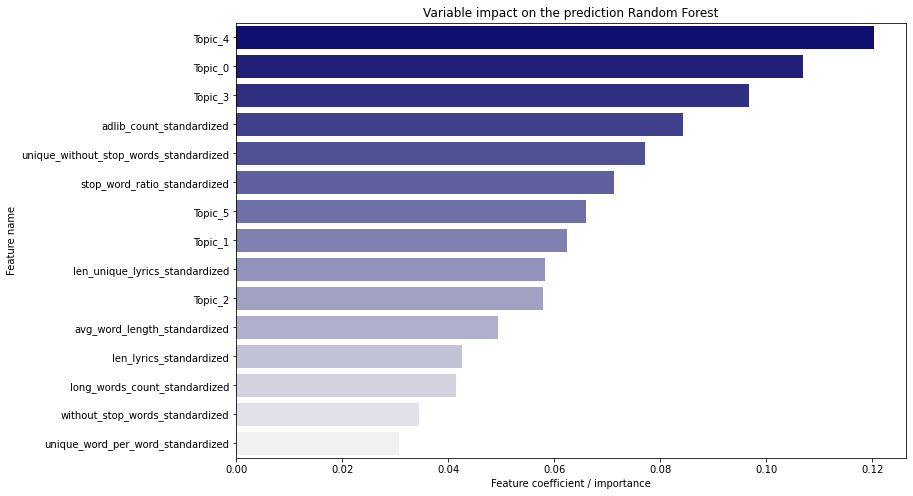

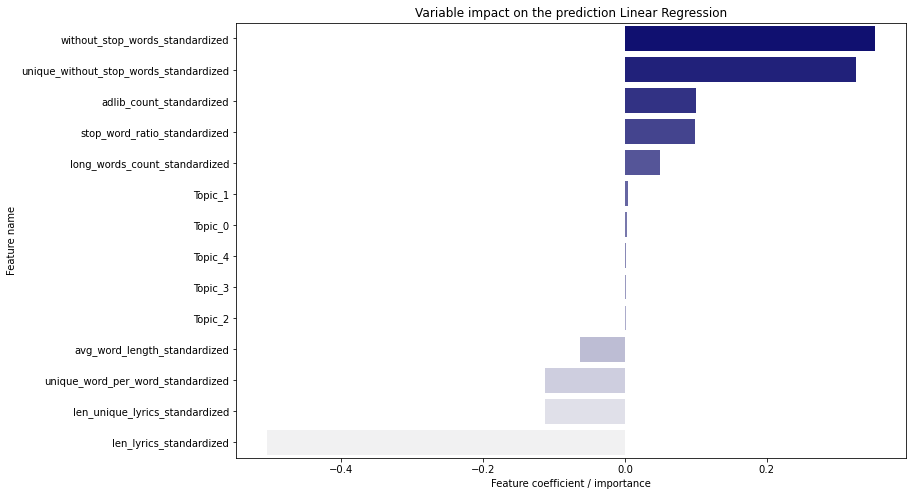

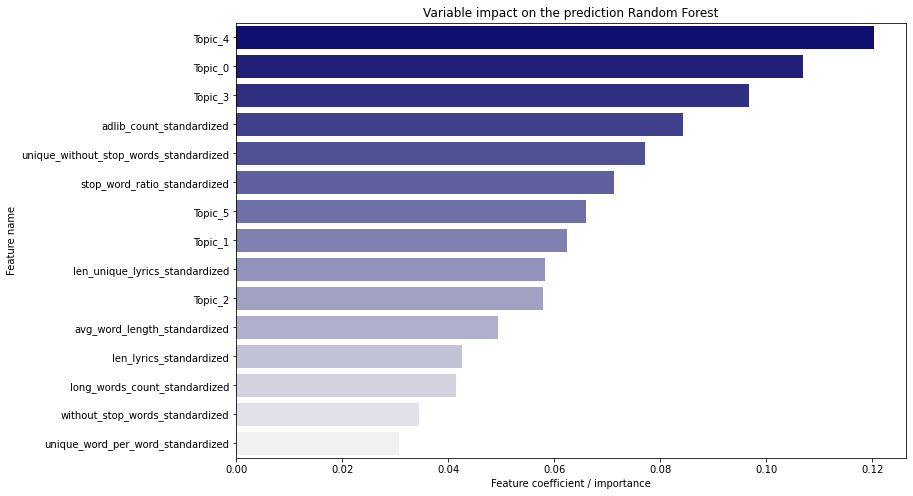

In [94]:
# import seaborn as sns
def top_10_plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Set palette color
    #blue_palette = sns.color_palette("Blues", as_cmap=True)
    #sns.set_palette(blue_palette)
    #Define size of bar plot
    fig = plt.figure(figsize=(12,8))
    #Plot Searborn bar chart
    navy_palette = sns.light_palette("navy", reverse=True, n_colors=len(fi_df))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=navy_palette)

    #Add chart labels
    plt.title('Variable impact on the prediction ' + model_type)
    plt.xlabel('Feature coefficient / importance')
    plt.ylabel('Feature name')

    return fig

top_10_plot_feature_importance(model_lr.coef_, X.columns, 'Linear Regression')
top_10_plot_feature_importance(model_rf.feature_importances_, X_train.columns, 'Random Forest')

## Conlcusions

The best model is the random forest with standardized label, with the runner up as far as standardized labels go being the linear regression. We believe that we can conclude, that for this problem standardizing the label makes sense, as it coincides with better performance of the models. It also seems to be intuitive, as we can expect that the artists have their own styles, and as such its hard to compare their lyrics between them in order to extract insights into the performance of their songs.

We find it interesting, however not extremely suprising that the best models were based on linear regression and random forest. They are both relatively simple models, with the random forest being on the simpler side of the ensamble models. Hence, in an environment with many complex interactions between the variables, an environment most likely not very hospitible to modeling and an environment without many observations in the sample, we can expect those simple models to perform. They are less prone to overfitting, and can still catch most of the variance to be captured in this scenario.

We also find it interesting, that a much greater emphasis was put on the topic features in the case of random forest, as compared to the linear regression. We are not sure why this occured. We assume that this might be the case because random forest is able to incorporate the relationships between the variables into the model, while linear regression does not have such an ability. Maybe in the feature importance of the topics in random forest we see the relationships between the topic variables and the other features.